In [97]:
import sys
sys.path.insert(0, "/Users/Elias/miso_research")
from miso.metrics.conllu import load_conllu
from collections import defaultdict

In [98]:
class AttachmentScoreCounter:
    def __init__(self):
        self.total = 0
        self.correct_head = 0
        self.correct_label = 0
        
    def __call__(self, true_head, pred_head, true_deprel, pred_deprel):
        self.total += 1
        if true_head == pred_head:
            self.correct_head += 1
        if true_deprel == pred_deprel:
            self.correct_label += 1
    
    def get_uas(self):
        return self.correct_head / self.total
    
    def get_las(self):
        return self.correct_label / self.total

def per_type_accuracy(true_file, pred_file, normalize_by_total = False):
    with open(true_file) as tf, open(pred_file) as pf:
        true_data = load_conllu(tf)
        pred_data = load_conllu(pf)
    assert(len(true_data.words) == len(pred_data.words))
    
    per_deprel_counters = defaultdict(lambda: AttachmentScoreCounter())
    
    for tw, pw in zip(true_data.words, pred_data.words):
        assert(tw.columns[0] == pw.columns[0])
        
        if tw.parent is None:
            assert(tw.columns[7] == "root")
            true_parent_idx = tw.columns[6]
        if pw.parent is None:
#             assert(pw.columns[7] == "root")
            pred_parent_idx = pw.columns[6]
    
        if tw.parent is not None and pw.parent is not None:  
            true_parent_idx = tw.parent.columns[0]
            pred_parent_idx = pw.parent.columns[0]
            
        true_deprel = tw.columns[7]
        pred_deprel = pw.columns[7]
        
        per_deprel_counters[true_deprel](true_parent_idx, pred_parent_idx, true_deprel, pred_deprel)
        
    per_deprel_uas = {k:v.get_uas() for k, v in per_deprel_counters.items()}
    per_deprel_las = {k:v.get_las() for k, v in per_deprel_counters.items()}
    
    totals = {k: v.total for k, v in per_deprel_counters.items()}
    if normalize_by_total:
        total_total = sum(totals.values())
        percentages = {k: v/total_total for k,v in totals.items()}
        per_deprel_uas = {k: v * percentages[k] for k, v in per_deprel_uas.items()}
        per_deprel_las = {k: v * percentages[k] for k, v in per_deprel_las.items()}
        
    return per_deprel_uas, per_deprel_las, totals
        
        

In [99]:
uas_dict_with_uds, las_dict_with_uds, totals = per_type_accuracy("en-ud-dev.conllu", "dev.conllu", False)
uas_dict_no_uds, las_dict_no_uds, __ = per_type_accuracy("en-ud-dev.conllu", "syntax_only_dev.conllu", False)



In [100]:
from matplotlib import pyplot as plt 
import seaborn as sns 
import pandas as pd




uas_deltas = {k: uas_dict_with_uds[k] - uas_dict_no_uds[k] for k in uas_dict_with_uds.keys()}
las_deltas = {k: las_dict_with_uds[k] - las_dict_no_uds[k] for k in las_dict_with_uds.keys()}

def trim_to_topk(data, top_k, by_total=False):
    # either take top k by total number of examples, 
    if by_total:
        sorted_data = sorted(data.items(), key=lambda x: totals[x[0]])[-top_k:]
    # or top k by absolute value of delta 
    else:
        sorted_data = sorted(data.items(), key=lambda x: abs(x[1]))[-top_k:]
    to_ret = {k: v for k,v in sorted_data}
    
    return to_ret

# only look at K biggest by absolute value 
uas_deltas = trim_to_topk(uas_deltas, 10, True)
las_deltas = trim_to_topk(las_deltas, 10, True)



uas_deltas_sorted = sorted(uas_deltas.items(), key=lambda x: totals[x[0]])
las_deltas_sorted = sorted(las_deltas.items(), key=lambda x: totals[x[0]])


uas_df = pd.DataFrame(uas_deltas_sorted, columns=["deprel", "delta"])
las_df = pd.DataFrame(las_deltas_sorted, columns=["deprel", "delta"])




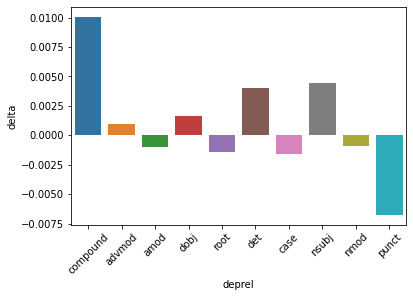

In [101]:
ax  = sns.barplot(x="deprel", y="delta", data=uas_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)

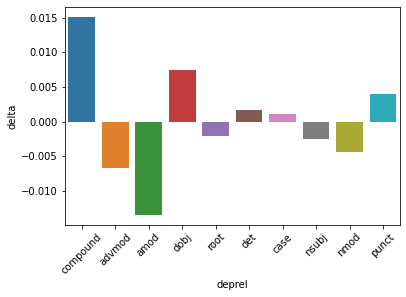

In [102]:
ax  = sns.barplot(x="deprel", y="delta", data=las_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)

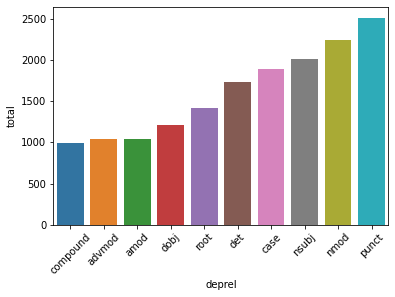

In [103]:
total_df = pd.DataFrame(sorted(totals.items(), key=lambda x:x[1])[-10:], columns=["deprel", "total"])

ax  = sns.barplot(x="deprel", y="total", data=total_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)